We will use the Henon map as an example to implementat the algorithm of calculating the Lyapunov exponents in discrete maps and use it to analyze the system. The map is defined as follows:
$$
\begin{array}{c}
\dot{x} = 1 - a x^2 + y, \\
\dot{y} = b x.
\end{array}
$$

First let us import some stuff, define the map and test that it works.

If you do not have any packages below, install them now, so you do not have to restart the kernel later on (not all of them are completely necessary, e.g. termcolor is only used for decorated colored outputs in some functions for better readability)

In [2]:
import os
import numpy as np
from numpy import linalg as LA
import math
import random
import scipy
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from icecream import ic
import unittest
import pytest
from termcolor import colored

We will define the map function with vector argument as input in the form
$$
\vec{x}_{n+1} = f (\vec{x}_n),
$$
where $\vec{x} = (x^0, x^1)^T$ (column vector) and
$$
f (\vec{x}) = \left(
\begin{array}{c}
 1 - a (x^0)^2 + x^1 \\
b x^0
\end{array}
\right)
$$

(I will use upper indicies for the vector components and the lower ones for the number of iteration of the map to avoid ambiguities).


It leads to slightly less readable code, but this approach scales better with increasing dimensionality of the system, compared to individually passing phase variables. One could also consider passing all the parameters as a singular vector of parameters (not recommended if there are not too many parameters).

To test the function, we will use some obvious cases of stable equilibrium points and check the dimensionality of the output vectors (it's important to see if they are returned correctly or transposed, etc.). In practice it is not so much a test coverage, as it is a sanity check in case of typos or bad import from some tools where you constructed the symbolic equations.

The first and the most simple sanity check is for a zero input vector, as it should return $(1,0)$ for arbitrary $(a,b)$.

Further analyzing the equations by hand, we see that an equilibirium point should satisfy $x^1 = b x^0$ and the quadratic equation
$$
1 - a (x^0)^2 + b x^0 = (x^0),
a (x^0)^2 - (b - 1) x^0 - 1 = 0.
$$
Since we do it to achieve a little understanding of the map an get some test cases, we can simplify and limit ourselves to considering the case $b=1$. Then
$$ x^0 = \pm \frac{1}{\sqrt{a}}. $$
For linear stability analysis let us consider the Jacobian matrix
$$
J = \left(
\begin{array}{cc}
 - 2 a x^0 &  1 \\
 b & 0
\end{array}
\right)
$$
In general, it has the following eigenvalues: $\lambda_{1,2}=-a x^0  \pm \sqrt{ (a x^0)^2 + b }$. For $b=1, x_0=\pm 1/\sqrt{a}, x_1= \pm b/\sqrt{a}$, we have
$$
\lambda_{1,2}|_{x^0=1/\sqrt{a}} = - \sqrt{a} \pm \sqrt{a+1}, \\
\lambda_{1,2}|_{x^0=-1/\sqrt{a}} = \sqrt{a} \pm \sqrt{a+1}.
$$
Therefore we have two equilibrium points $x^0 = \pm 1/\sqrt{a}$, and both of them are saddles for all real $a>0$. These points give us good test cases for the map itself and the linearized system along the trajectory.

Here I will incorporate unit test framework for testing the majority of the functions that calculate something and have well-defined input-output kinda thing to demonstrate how it can be implemented in this kind of problems. Sometimes it can be an overkill, but I think it's a good thing to have in mind just in case, because it can be of help. I will be mostly defining the tests in the some cells as the functions they refer to, so that if you do some changes to the target function and execute, it automatically reruns the tests and you can check if they passed, or you changes ruined the expected behavior somewhere. In a bigger project with different files with the functions and main script, you would probably dedicate a separate file with all the test functions that would automatically run after implementing some changes to the target functions.

In [6]:
#def henon_map(a,b, x, y):
    #return 1 - a*x**2 + y, b*x
    #this implementation might be more clear for the first time
    
def henon_map(a, b, x):
    return np.array([1 - a*x[0]*x[0] + x[1], b*x[0]])


class TestTheMap(unittest.TestCase):
    dim=2 #define the dimension
    def test_first_sanity_check(self):
        a=0
        b=0
        test_input=np.array([0, 0])
        expected_out=np.array([1, 0])
        self.assertTrue(np.array_equal(henon_map(a, b, test_input), expected_out)) #output
        #because comparing arrays is ambiguous in python
        self.assertEqual(henon_map(0, 0, np.array([0, 0])).shape, (self.dim,)) #dimension

        a=1
        b=1
        self.assertTrue(np.array_equal(henon_map(1, 1, test_input), expected_out))
        self.assertEqual(henon_map(1, 1, np.array([0, 0])).shape, (self.dim,))
    
    def test_dimension(self):
        a,b=np.random.rand(self.dim,)
        x=np.random.rand(self.dim,)
        self.assertEqual(henon_map(a, b, x).shape, (self.dim,))
        
    def test_equilibrium(self):
        a=np.random.rand(1).item()
        b=1
        x=np.array([1/np.sqrt(a), b/np.sqrt(a)])
        y=henon_map(a, b, x)
        #ic(x)
        #ic(y)
        #ic(np.allclose(x, x, atol=1e-6))
        self.assertTrue(np.allclose(y,x, atol=1e-6))
        x2=-x
        y2=henon_map(a, b, x2)
        self.assertTrue(np.allclose(y2,x2, atol=1e-6))
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_dimension (__main__.TestTheMap) ... ok
test_equilibrium (__main__.TestTheMap) ... ok
test_first_sanity_check (__main__.TestTheMap) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


For $x^0=1/\sqrt{a}$ and $\lambda_{1,2}=- \sqrt{a} \pm \sqrt{a+1}$, we can calculate the eigenvectors (here I did it by hand, but in real high-dimensional systems use some symbolic linear algebra tools):
$$
\vec{v}^1_{1,2} = \left(
\begin{array}{c}
- \sqrt{a} \pm \sqrt{a+1}  \\
1
\end{array}
\right)
$$
And for $x^0=-1/\sqrt{a}$ and $\lambda_{1,2}= \sqrt{a} \pm \sqrt{a+1}$, we have
$$
\vec{v}^2_{1,2} = \left(
\begin{array}{c}
\sqrt{a} \pm \sqrt{a+1} \\
1
\end{array}
\right).
$$
Using the eigenvectors we can check the linear system for perturbation vectors.

In [8]:
def henon_pert(a,b,x,dx):
    """Henon map + one linear perturbation vector evolution"""
    x_=henon_map(a,b,x)
    J=np.array([[-a*2*x[0], 1],
                [b, 0]])
    #ic(J.shape)
    #ic(dx.shape)
    dx_=np.matmul(J,dx) # J*dx gives the one step of linear perturbation
    #ic(dx_.shape)
    return x_, dx_

class TestVariations(unittest.TestCase):
    dim=2 #DIMENSION
    def test_first_sanity_check(self):
        expected_out=np.array([1, 0])
        expected_out_perturb=np.zeros((2,2)) #for all zero perturbations
        x_, dx_ = henon_pert(0, 0, np.array([0, 0]), np.zeros((2,2)))
        self.assertTrue(np.array_equal(x_, expected_out))
        self.assertTrue(np.array_equal(dx_, expected_out_perturb))

        self.assertEqual(x_.shape, (2,))
        self.assertEqual(dx_.shape, (2,2))
    
    def test_dimension(self):
        rng = np.random.default_rng()
        a,b=rng.random((self.dim,))
        x=rng.random((self.dim,))
        dx=rng.random((self.dim,self.dim))
        y, dy=henon_pert(a,b,x,dx)
        self.assertEqual(y.shape, (self.dim,))
        self.assertEqual(dy.shape, (self.dim,self.dim))
        
    def test_first_equilibrium(self):
        rng = np.random.default_rng()
        a=rng.random((1,)).item()
        b=1
        x=np.array([1/np.sqrt(a), 1/np.sqrt(a)])
        lambda_1= -np.sqrt(a)+np.sqrt(a+1)
        lambda_2= -np.sqrt(a)-np.sqrt(a+1)
        eigen_vec_1= np.array([-np.sqrt(a)+np.sqrt(a+1), 1])
        eigen_vec_2= np.array([-np.sqrt(a)-np.sqrt(a+1), 1])
        dx=np.concatenate((eigen_vec_1, eigen_vec_2)).reshape((-1, self.dim), order='F')
        y, dy=henon_pert(a, b, x, dx)
        
        #ic(x)
        #ic(y)
        #ic(np.allclose(x, x, atol=1e-6))
        self.assertTrue(np.allclose(y,x, atol=1e-6))
        self.assertTrue(np.allclose(dy,
                        np.concatenate((lambda_1*eigen_vec_1, lambda_2*eigen_vec_2)).reshape((-1, self.dim), order='F'), atol=1e-6))
        
    def test_second_equilibrium(self):
        rng = np.random.default_rng()
        a=rng.random((1,)).item()
        b=1
        x=np.array([-1/np.sqrt(a), -b/np.sqrt(a)])
        lambda_1= np.sqrt(a)+np.sqrt(a+1)
        lambda_2= np.sqrt(a)-np.sqrt(a+1)
        eigen_vec_1=np.array([np.sqrt(a)+np.sqrt(a+1), 1])
        eigen_vec_2=np.array([np.sqrt(a)-np.sqrt(a+1), 1])
        dx=np.concatenate((eigen_vec_1, eigen_vec_2)).reshape((-1, self.dim), order='F')
        y, dy=henon_pert(a, b, x, dx)
        
        #ic(x)
        #ic(y)
        #ic(np.allclose(x, x, atol=1e-6))
        self.assertTrue(np.allclose(y,x, atol=1e-6))
        self.assertTrue(np.allclose(dy,
                            np.concatenate((lambda_1*eigen_vec_1, lambda_2*eigen_vec_2)).reshape((-1, self.dim), order='F'), atol=1e-6))
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_dimension (__main__.TestTheMap) ... ok
test_equilibrium (__main__.TestTheMap) ... ok
test_first_sanity_check (__main__.TestTheMap) ... ok
test_dimension (__main__.TestVariations) ... ok
test_first_equilibrium (__main__.TestVariations) ... ok
test_first_sanity_check (__main__.TestVariations) ... ok
test_second_equilibrium (__main__.TestVariations) ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.009s

OK


It is not necessary to test always test every function this way every time. Sometimes it can be an overkill, and more simple checks can suffice, but imho it is good to have a general idea about diferrent approaches you could use for testing/debugging this kind of programms in addition to usual testing by hand with debug prints, graphs, etc.


Easily analyzed fixed points are often not available, but it is a good thing to try finding some test cases neveretheless. The parameter values, where you can analyze not only the signature of the exponents (sanity check), but how the numbers converge are valuable for various estimates. Usually in a new system I would try to find some parameters, corresponding to edge/degenerate cases where it reduces to a more simple system that was studied elsewhere, or where it is easy to see if something is true/wrong (e.g. by setting almost all of the parameters to zeroes and ones or something similar, when the expected behavior is really simple, just to see if at least everything works there).

Regarding the normaliztion of the perturbation vectors in the Benettin algorithm. Consider the system
$$
\vec{x}_{n+1}=F(\vec{x}_n).
$$
Adding small perturbations $\vec{\widetilde{x}}_n = \vec{x} + \delta \vec{x}_n$ and expanding the right-hand side into the Taylor series, we get
$$
\vec{\widetilde{x}}_{n+1} = F(\vec{x}_n + \delta \vec{x}_n) = F(\vec{x}_n) + \left. J\right|_{\vec{x}_n} \delta \vec{x}_n + O\left( || \delta \vec{x}_n ||^2 \right),
$$
where $\left. J\right|_{\vec{x}_n} = \partial F_i/ \partial x^j$ is the Jacobian matrix evaluated in the point $\vec{x}_n$. Given that a small (theoretically, infinitisemal) perturbation on step $n$ leads a perturbation of the same order of magnitude at the next step $n+1$, and  that $\vec{x}_{n+1} = F(\vec{x}_n$ correspondonds to the unperturbed trajectory. Notice that at this point it is important for $|| \delta \vec{x}_n ||$ to be small, so that the series expansion and the derivation of the following linear system for the evolution of the perturbation works:
$$
\vec{\widetilde{x}}_{n+1} = \vec{x}_{n+1} + \delta \vec{x}_{n+1} \approx F(\vec{x}_n) + \left. J\right|_{\vec{x}_n} \delta \vec{x}_n, \\
\delta \vec{x}_{n+1} =  \left. J\right|_{\vec{x}_n} \delta \vec{x}_n.
$$
Notice that that the **linear** system describing the evolution of perturbation vectors $\delta \vec{x}_{n}$ is linked to the initial non-linear model only via the the Jacobi matrix $\left. J\right|_{\vec{x}_n} \delta \vec{x}_n$ evaluated at the point $\vec{x}_n$. Now also see that any linear system $\vec{y}_{n+1} = A \vec{y}_n$ is scale-free, i.e. vector $\vec{y}$ can be scaled by an arbitrary factor $\alpha \neq 0$, preserving the equations. Thus, if we now construct the algorithm of computing the Lyapunov exponents using considering only the linear term describing the perturbations evolution, discarding all the higher-order terms, we can get rid of the restriction of small norms $|| \delta \vec{x}_n ||$, and normalize the basis of the perturbation vectors to one without loss of generality $|| \delta \vec{x}_n || = 1$. So, now our algorythm looks as follows:

1. For given parameter values $a,b$ get the initial conditions $\vec{x}_0$ on the attractor by iterating the map a certain number of times.

2. Initialize the orthonormal basis of perturbations vectors $\delta X = ( \delta \vec{x}^{(1)}, ... \delta \vec{x}^{(d)}$, where $d$ is the dimensionality of the system. The usual way is to use the identity matrix, as it already represents a set of $d$ orthogonal vectors w/ norms of $1$ concatenated into a square matrix. Initialize a zero-vector $\vec{S} = (S^1, ..., \S^d)$ that will contain the Lyapunov sums.

3. For $\vec{x}_i$, starting from $\vec{x}_0$, evaluate the Jacobian at $\vec{x}_i$, iterate the map together with the linear map for perturbation vectors. A convenient and efficient implementation is to concatenate/stack $d$ column-vectors into a square matrix $\delta X$ and pass it as a single argument. The one step of evolution of the perturbation vectors is then given by $\delta Y = \left. J\right|_{\vec{x}_n} \delta \vec{x}_n \delta X$.

4. Use the QR-decomposition on $\delta Y$. The diagonal elements of R-matrix contain the norms of the perturbation vectors, and Q-matrix is orthogonal, containing the new set of orthogonal vectors and normalized to one, i.e. the new $\delta X$ for the next iteration $i+1$. Thus, $S^k = S^k + \log | R_{kk}|, k=1..d $ (if implemented in numpy, can be done as $S = S + np.log(np.abs(np.diag(R)))$

5. Repeat steps 2-4 $M$ times. It can be a predefined by certain considerations number of iterations or meeting a convergence condition. The Lyapunov exponents will be $\lambda = S/M$ (packed into a $d$-dimensional vector.

However, setting a convergence condition for the Lyapunov exponents is quite tricky, because the convergence can be quite slow. **A very important caveat** is that the Lyapunov exponents are an **average** characteristic of a given attractor. For an attractor (that is not a fixed point), the expansion/contraction rates along the invariant subspaces of the linear system defined by the Jacobian matrix $\left. J\right|_{\vec{x}_i}$ can change significantly in different points ${\vec{x}_i}$. It means that for two consecutive iterations $i-1, i$, a small difference between the computed values of the exponents $||\lambda_{i} - \lambda_{i-1}|| < \varepsilon$ (I would usually use $L_{\infty}$ norm here, so we measure the maximal component in the vector of differences) is not indicative that it will be small for the next iterations $i, i+1$, i.e. it can be $||\lambda_{i+1} - \lambda_{i}|| > \varepsilon$. This can lead to noticable oscillations in the values of the exponent even after quite a large number of iterations (with growing number of iterations, the oscillations slowly decay). Thus, to set the stop-condition, we must average out the measured differences over a sufficiently large number of iterations $N_c$, where the fluctuations smooth out, comparing $||\lambda_{i} - \lambda_{i-N_c}||$ with $\varepsilon$. Moreover, a sensible number $N_c$ can noticably vary for different attractor correspondong to different parameter values.\\

In practice I would maybe place it in the algorithm as a kind of contingency measure against calculating for too long when we encounter a somewhat trivial attractor for which the convergence rate is much faster (although for trivial attractors, computations are usually much faster anyway, bc of faster map iteration, built-in caching, etc.). However, this requires quite a large $N_c$ be more or less universally applicable for your function to work properly in one- or two-parameter analysis, because in real problems, the exponents require quite large number of iterations. HIn practice it is often easier to determine a sensible number of iterations required for a reasonable convergence (by doing a number of computational experiments with different attractors) and use it universally. It also leads to more predictable perfomance of your functions time-wise. Another potential problem is that $N_c$ and $\varepsilon$ are not really independent: changing desirable tolerance $\varepsilon$ might require a corresponding change in $N_c$, but the relationship is not trivial (something like $N_c \sim O(1/\varepsilon)$ comes to mind, but the coefficient is unknown, and can be more than 10, so idk).

The problem with setting the stop-condition by convergence can be demonstrated on the Henon map. In my experiments I've observed that for the condition to work on the chaotic attractor at $a=1.4, b=0.3$ with tolerance $\varepsilon=10^{-4}$, the number of iterations betwen the checking the difference $||\lambda_{i} - \lambda_{i-N_c}||$ needs to be around $N_c=2 \cdot 10^5$, which is much larger then you would probably anticipate. I will demonstrate it after the main tests by printing the values of the exponents with interim results for different number of iterations, where you can notice the oscillations of the exponents even after a large number of map iterations to highlight the problem of a potential early interruption, when real error can be several times larger then set level $\varepsilon$ after exiting the function (like $4 \cdot \varepsilon$ or $5 \cdot \varepsilon$). Alternatevily, you could use the condition as a rough estimation of order of magnitude of your error, e.g. you could use $N_c=10^5$ and $\varepsilon=10^{-4}$, and you can reasonably assume that your real error is less then $10^{-3}$.

each $N_c$ iterations for different values. You will see that even for such numbers as $50k$ iterations, the difference between consecutive values of $\lambda_{i-N_c}, \lambda_{i}$ can sometimes be small, and then become larger again. It highlights the problem of early interruption, i.e. the function would exit the cycle assuming the tolerance of $\varepsilon$ is reached, when in reality, it can be several times more than that (but probably in the same order of magnitude), like $\varepsilon$ away from the true values. 

Overall, an often used approach of just setting a fixed sufficiently large number of iterations $M$ that you choose after a decent number of computational experiments with different parameters, and then using it universally is fine (and occasionally doing sanity checks if you start encountering attractors with different structures). Moreover, as the Lyapunov exponents are often used as a more of a qualitative than a quantitative measure, we are generally more interested in the order of magnitude of the error, (like $10^{-3}$ or $10^{-4}$), than in the particular value, and it is somewhat hard to specify by hard-coding a stop-condition.

*Note regarding item 6: for contionuous-time system it can be more tricky, as there will be another hyper-parameter corresponding to the amount of time between reorthogonalizations, and $N_c$ will also depend on it.

The Henon map is also a little tricky, because there exist trajectories escaping to infinity via an unstable manifold of a saddle for some parameter values, so we need to be careful and actually check the numerical divergencies/convergencies to an attractor before calculating the exponents. In this particular case I want to include the flag with info on divergence into the 'skip_ics' function. There is freedom of imagination on how you want to handle that, but one should check if the initial conditions are okay before passing them into the cycle computing the Lyapunov exponents.

In [15]:
def skip_ics(a,b,x_0,n_iter=200, upper_threshold=1e6):
    """iterate first n_iter steps before convergence to the attractor"""
    convergence_flag=True
    x=x_0
    for i in range(n_iter):
        x_new=henon_map(a,b,x)

        if np.any(np.abs(x_new)>upper_threshold) or np.any(np.isnan(x_new)):
            convergence_flag=False
            x=x_0
            return x_0, convergence_flag
        x=x_new
        
    return x, convergence_flag

To test the convergence of the Lyapunov exponents, we will use the two saddle points and the chaotic attractor. It is a bit tricky, to test convergence in the saddle points, as the system might slowly escape them via the unstable manifold due to imperfect numerical precison, so we'll some tricks. The test on the chaotic attractor can be done within the unittest framework, as we only need to comapare the values so we'll discuss it first, and the tests on the saddle points after that. We will use the precomputed exponents values for the chaotic attractor at $b=0.3, a=1.4$. In practice this would be done by picking these value elsewhere for some values of the parameters, for which your system degenerates to an already stuided case. It could be investigated either in some existing papers, or maybe studeied by yourself in a more simple model in your earlier research.

It is also okay that the earlier tests will re-run again, as those are fast anyway, and some of them use random initializations, so it's ok to re-run them with different generated values. Alternatively, we could define the tests in the cells with functions, and then execute them all at once later. Or, in a more practicalprojects, you would probably make a separate file with all the tests, which would run after any changes in the corresponding functions.

In [19]:
def calc_max_lyap(a,b,x_0,n_iter=10**4):
    """for only the maximal lyap exponent;
    a,b - parameters;
    x_0 - initial conditions vector;
    vec_norm CAN ALWAYS BE SCALED TO 1
    In this case the perturbation vector dx is initialized inside the calc_ function, could be
    passed as an argument instead"""
    S=0
    rng = np.random.default_rng()
    dx=rng.random(2) #perturbation vector initialization
    dx_=np.divide(dx, np.linalg.norm(dx)) #normalization to vec_norm
    x_=x_0 #the variable i'll be using inside the loop
    for i in range(n_iter):
        x, dx=henon_pert(a,b,x_, dx_) #one step of 2d map + one 2d linear system for perturbation
        
        S=S+np.log(LA.norm(dx)) #accumulating the Lyapunov sum
        
        dx_=np.divide(dx, LA.norm(dx))
        x_=x
        #could also be Ss/i to show the convergence of the exponents to constants, but usually looks
        #a bit uglier
    L=S/n_iter #The Lyapunov exponent from the sum
    return L, Ss


# def lyap_one_step(a,b,x_,dxs_):
#     x, dxs=henon_pert(a,b,x_, dxs_)
#     Q, R=np.linalg.qr(dxs)
#     d_exp=np.absolute(np.diag(R))
#     dS=np.log(d_exp)
#     return x, Q, dS

def calc_lyap_spectre(a,b,x, tolerance=1e-4, max_iterations=2*10**6, check_frequency=200000):
    """Implementation of the function with a stop condition and N_c=2*10^5. Here we assume that input x is on an attractor,
    and the exceptions of Nans and large numbers were handled earlier"""
    dim=2
    S=np.zeros(dim)
    dxs_=np.eye(dim)
    x_=x
    tolerance_reached=False
    #check_frequency=1000
    L1=np.zeros(dim) 
    L2=np.zeros(dim) #L1 and L2 will be used for the comparisons in the tolerance check
    M=1 #just in case so it's not zero
    
    for i in range(max_iterations):
        #It is sensible to use this form of cycle, if we want to have a maximum acceptable number of iterations anyway
        x, dxs = henon_pert(a,b,x_, dxs_)
        Q, R=LA.qr(dxs)
        d_exp=np.absolute(np.diag(R))
        dS=np.log(d_exp)
        
        x_=x
        dxs_=Q
        S = S + dS
        
        if i%check_frequency==0:
            M=i+1
            L2=np.divide(S, M)
            #print(L2)
            #Gives weird results with  tolerance_reached2=np.allclose(L1,L2,atol=tolerance)
            tolerance_reached=np.all(LA.norm(L2-L1, np.inf) < tolerance)
            if tolerance_reached:
                #print("tolerance reached after", M, "iterations \n") #debug print
                return L2
            else:
                L1=L2
    if not tolerance_reached:
        M=max_iterations
        L=np.divide(S,M)
    #ic(M)
    #L=np.divide(S,M)
    return L



class TestLyapExponents(unittest.TestCase):
    dim=2 #DIMENSION
    
    def test_dimension(self):
        rng = np.random.default_rng()
        a,b=rng.random((self.dim,))
        x=rng.random((self.dim,))
        test_Lambda=calc_lyap_spectre(a,b,x)
        self.assertEqual(test_Lambda.shape, (self.dim,))
        
    def test_convergence_attractor(self):
        a=1.4
        b=0.3
        #rng = np.random.default_rng()
        x_0=np.array([0.5, 0.5]) # rng.random((self.dim,)) #
        x_attr, ics_converged=skip_ics(a,b,x_0)
        L_true=np.array([0.41904425, -1.62301705])
        if ics_converged:
            Ls=calc_lyap_spectre(a,b,x_attr)
            #print(Ls)
            self.assertTrue(np.all(LA.norm(Ls-L_true, np.inf) < 1e-4))
        else:
            print(Ls)
            pass
        
        

unittest.main(argv=[''], verbosity=2, exit=False)

test_convergence_attractor (__main__.TestLyapExponents) ... ok
test_dimension (__main__.TestLyapExponents) ... ok
test_dimension (__main__.TestTheMap) ... ok
test_equilibrium (__main__.TestTheMap) ... ok
test_first_sanity_check (__main__.TestTheMap) ... ok
test_dimension (__main__.TestVariations) ... ok
test_first_equilibrium (__main__.TestVariations) ... ok
test_first_sanity_check (__main__.TestVariations) ... ok
test_second_equilibrium (__main__.TestVariations) ... ok

----------------------------------------------------------------------
Ran 9 tests in 34.570s

OK


Ideally, we would want a stable equilibrium point for test case for the implementation of the Lyapunov exponents computing algorithm, as they should converge to the **logarithms of absolute values of the eigenvalues** of the Jacobi matrix in the point. If we have a stationary point $\vec{x}_s$ with Jacobi matrix $\left. J\right|_{\vec{x}_s}$, which has eigenvalues $\lambda_{1,2}$, then the Lyapunov exponents $\lambda^L_{1,2}$ (admiettedly, the name $\lambda$ is a little overloaded here) will be
$$
\lambda^L_{1,2} = \log \left( \left| \lambda_{1,2} \right| \right).
$$
(even if $\lambda$ are complex)

The meaning of eigenvalues of the matrix of a linearized system is a little different for discrete-time and contionuous-time systems. For a contionuous system, the signs of the real parts of the eigenvalues are responsible for the stability: positive real parts correspond to instabilities (the right half of the complex plane), and the eigenvalues with negative real parts - to stable manifolds. In a discrete map

$$
\vec{y}_{n+1} = A \vec{y}_n,
$$
the norm $||vec{y}||$ grows/decay depends on the absolute values of the eigenvalues of $A$: the eigenvalues within the unit circuit (of the complex plane) are responsible for stable manifolds, and those with $|\lambda_i| > 1$ - for the unstable ones. In this example, if fixed point $\vec{y}=0$ is a saddle with two real eigenvalues $\lambda_{1,2}$, if we currently care only about stability and do not care about rotations (i.e. the behaviour of $|| \vec{y} ||$, we can consider a system with diagonal matrix

$$
D = \left(
\begin{array}{cc}
\lambda_1 & 0 \\
0 & \lambda_2
\end{array}
\right).
$$

Then the variables effectively decouple, and $y^i_n = (\lambda_i)^n y^i_0 = e^{\log \left( \lambda_i \cdot n \right)}$ (index $i$ again corresponds to the vector components), and we see how $\log \left( \lambda_i \right)$ explicitly appears in place of the Lyapunov exponents. This example can be easily extended to a system of arbitrary dimensionality with a diagonanizable Jacobi matrix (or to the dimensions of the system cooresponding to the block with only diagonal elements in the Jordan form). Positive/negative signs of the eigenvalues in this case mean that the respective coordinate preserves it sign or switches it on each iteration.

Now, considering a two-dimensional linear system with 2 complex-conjugate eigenvalues $\lambda_{1,2}= a \pm i \omega$:

$$
\vec{y}_{n+1} = \left(
\begin{array}{cc}
a & -\omega \\
\omega & a
\end{array}
\right)
\vec{y}_n,
$$
the norm of the vector after one iteration $\vec{y}_1 = || A \vec{y}_0 || = \sqrt{\left(a^2 + \omega^2 \right) ||\vec{y}_0||^2} = \sqrt{a^2 + \omega^2} ||\vec{y}_0|| = |\lambda_{1,2}| ||\vec{y}_0||$. Thus, $||\vec{y}_n|| = |\lambda_{1,2}|^n ||\vec{y}_0|| = e^{\log \left( |\lambda_{1,2}| \cdot n \right)} ||\vec{y}_0||$, and we get the same result for two (identical) Lyapunov exponents, corresponding to this pair of conjugate eigenvalues. Given that any non-degenerate real matrix can be transformed (up to orthogonal tranformation, not affecting the norm of vector $\vec{y}$) to the shape of block-diagonal structure with either $2x2$ blocks, corresponding to complex-conjugate pairs of eigenvalues, or diagonal elements, corresponding to real eigenvalues, we can generalize this conclusion regarding the relationship between the eigenvalues of the Jacobi matrix in the fixed fixed point and the Lyapunov exponents.

An ideal test-case would be a stable/neutral fixed point. WIth saddles/unstable points, small numerical inaccuracies can lead to a drift the coordinates in the cycle within the algorithm, and eventually the system might escape from the equilibrium via one of its' unstable manifolds. To address this issue we need either very precise calculations or use a trick to force the system to stay in the fixed point. In Matlab, I was sometimes able to achieve numerical stability for saddle points without changing anything. In Python it depends, and we can test and see. Increasing numerical preciosion too much might slow down the computations and is often impractical. We can also use the following trick: in the Benettin algorithm we can repeatedly feed the same values $\vec{x}$ of the saddle point coordinates $\vec{x}=\vec{x}_{s}$, instead of getting a new state of the system on each iteration. This way, the state vector $\vec{x}$ is guaranteed to remain in the fixed point, while we keep the function for the perturbations without changes.

In theory, if we've implemented everything correctly, the perturbation vectors should eventually align with eigenvectors (or with the invariant 2-dimensional subspaces for the complex-conjugate eigenvalues when the eigenvectors do not exist), and the Lyapunov exponents should converge pretty quickly. I did not want to make the calc_lyap_spectre function too flexible and add too many optional arguments to allow for such non-typical use-cases, so I'll just copy-paste the code below and make some slight adjustments to allow for repeated feeding of the fixed-point coordinates. We can also print the Q and R matricies at the last iterations to see if the vectors in Q indeed align with eigenvectors, and logarithm of the absolute values of the diagonal elements of R would also correspond to the Lyapunov exponents (because if we have eigenvectors in dxs, then similar to the tests of henon_perturb, on each step we add dS equal to the exponents).

Coordinates:  [1.1009853 1.1009853] 

Eigenvalues:  [ 0.44263632 -2.259191  ] 

Log abs eigenvalues:  [ 0.81500678 -0.81500678] 

Calculated exponents:  [ 0.81500455 -0.81500455] 

Eigenvectors:
 [[ 0.40475734 -0.91442413]
 [ 0.91442413  0.40475734]]
Q matrix at the last iteration:
 [[-0.91442413  0.40475734]
 [ 0.40475734  0.91442413]]
R matrix at the last iteration:
 [[-2.25919100e+00  8.32667268e-17]
 [ 0.00000000e+00  4.42636324e-01]]
Log of diagonal elements of R matrix: [ 0.81500678 -0.81500678] 


____________________________________________

Saddle 2:

Coordinates:  [-1.1009853 -1.1009853] 

Eigenvalues:  [ 2.259191   -0.44263632] 

Log abs eigenvalues:  [ 0.81500678 -0.81500678] 

Calculated exponents:  [ 0.81500455 -0.81500455] 

Eigenvectors:
 [[ 0.91442413 -0.40475734]
 [ 0.40475734  0.91442413]]
Q matrix at the last iteration:
 [[-0.91442413 -0.40475734]
 [-0.40475734  0.91442413]]
R matrix at the last iteration:
 [[ 2.25919100e+00  8.32667268e-17]
 [ 0.00000000e+00 -4.426

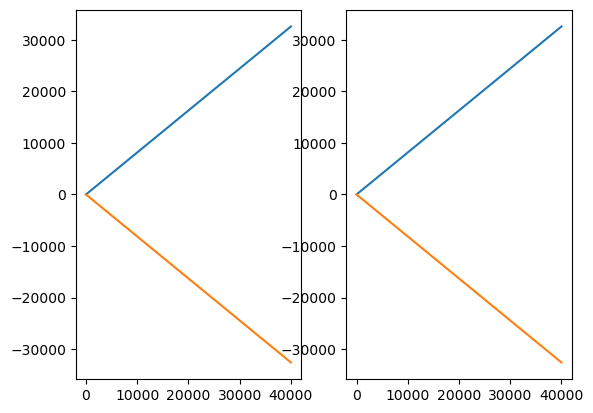

In [38]:
rng = np.random.default_rng()
a=rng.random((1,)).item() #a=1
b=1
dim=2

x_s1=np.divide(np.array([1, b]), np.sqrt(a))
lambda_1_s1 = -np.sqrt(a)+np.sqrt(a+1)
lambda_2_s1 = -np.sqrt(a)-np.sqrt(a+1)
lambda_s1=np.array([lambda_1_s1, lambda_2_s1])

eigen_vec_1_s1 = np.array([-np.sqrt(a)+np.sqrt(a+1), 1])
eigen_vec_1_s1 = np.divide(eigen_vec_1_s1, LA.norm(eigen_vec_1_s1))

eigen_vec_2_s1 = np.array([-np.sqrt(a)-np.sqrt(a+1), 1])
eigen_vec_2_s1 = np.divide(eigen_vec_2_s1, LA.norm(eigen_vec_2_s1))
EVs_s1=np.concatenate((eigen_vec_1_s1, eigen_vec_2_s1)).reshape((-1, dim), order='F')



S=np.zeros(dim)
dxs_=np.eye(dim)
dS=np.zeros(dim)

tolerance_reached=False
tolerance=1e-4
check_frequency=20000
max_iterations=40000
L1=np.zeros(dim) 
L2=np.zeros(dim) #L1 and L2 will be used for the comparisons in the tolerance check
#M=1 #just in case so it's not zero
M=1

Ss_s1=np.zeros((dim, max_iterations))
x_=x_s1

for i in range(max_iterations):
    #It is sensible to use this form of cycle, if we want to have a maximum acceptable number of iterations anyway
    x, dxs = henon_pert(a,b,x_, dxs_)
    Q, R=LA.qr(dxs)
    d_exp=np.absolute(np.diag(R))
    dS=np.log(d_exp)
    
    #x_=x
    #REMOVING UPDATE x_
    dxs_=Q
    S = S + dS

    Ss_s1[:,i]=S
    
    if i%check_frequency==0:
        M=i+1
        L2=np.divide(S, M)
        tolerance_reached=LA.norm(L2-L1, np.inf) < tolerance
        if tolerance_reached:
            #print('Tolerance reached after ', M-1, 'iterations\n')
            Ls_s1=L2
        else:
            L1=L2

if not tolerance_reached:
    M=max_iterations
    Ls_s1 = np.divide(S, M)

#Ls_s1=np.divide(S,M)

print(colored('Coordinates: ', 'red'), x_s1, '\n')
print(colored('Eigenvalues: ', 'blue'), lambda_s1, '\n')


print(colored('Log abs eigenvalues: ', 'blue'), np.sort(np.log(np.abs(lambda_s1)))[::-1], '\n')
print(colored('Calculated exponents: ', 'green'), Ls_s1, '\n')

print(colored('Eigenvectors:\n', 'blue'), EVs_s1)
print(colored('Q matrix at the last iteration:\n', 'blue'), Q)

print(colored('R matrix at the last iteration:\n', 'blue'), R)
print(colored('Log of diagonal elements of R matrix:', 'blue'), dS, '\n')

plt.figure(1)

plt.subplot(121)
plt.plot(Ss_s1[0,:])
plt.plot(Ss_s1[1,:])


x_s2=np.array([-1/np.sqrt(a), -b/np.sqrt(a)])
lambda_1_s2 = np.sqrt(a)+np.sqrt(a+1)
lambda_2_s2 = np.sqrt(a)-np.sqrt(a+1)
lambda_s2=np.array([lambda_1_s2, lambda_2_s2])

eigen_vec_1_s2 = np.array([np.sqrt(a)+np.sqrt(a+1), 1])
eigen_vec_1_s2 = np.divide(eigen_vec_1_s2, LA.norm(eigen_vec_1_s2))
eigen_vec_2_s2 = np.array([np.sqrt(a)-np.sqrt(a+1), 1])
eigen_vec_2_s2 = np.divide(eigen_vec_2_s2, LA.norm(eigen_vec_2_s2))
EVs_s2=np.concatenate((eigen_vec_1_s2, eigen_vec_2_s2)).reshape((-1, dim), order='F')

Ss_s2=np.zeros((dim, max_iterations))
S=np.zeros(dim)
dxs_=np.eye(dim)
dS=np.zeros(dim)

for i in range(max_iterations):
    #It is sensible to use this form of cycle, if we want to have a maximum acceptable number of iterations anyway
    x, dxs = henon_pert(a,b,x_s2, dxs_)
    Q, R=LA.qr(dxs)
    d_exp=np.absolute(np.diag(R))
    dS=np.log(d_exp)
    dxs_=Q
    S = S + dS
    Ss_s2[:,i]=S

Ls_s2=np.divide(S, max_iterations)

print(colored('\n____________________________________________\n', 'red'))
print(colored('Saddle 2:\n', 'green'))
print(colored('Coordinates: ', 'red'), x_s2, '\n')
print(colored('Eigenvalues: ', 'blue'), lambda_s2, '\n')


print(colored('Log abs eigenvalues: ', 'blue'), np.sort(np.log(np.abs(lambda_s2)))[::-1], '\n')
print(colored('Calculated exponents: ', 'green'), Ls_s2, '\n')

print(colored('Eigenvectors:\n', 'blue'), EVs_s2)
print(colored('Q matrix at the last iteration:\n', 'blue'), Q)

print(colored('R matrix at the last iteration:\n', 'blue'), R)
print(colored('Log of diagonal elements of R matrix:', 'blue'), dS, '\n')

print('\n See, how the columns in Q have aligned with the eigenvectors (up to enumeration).') 
print('And the the diagonal elements in R (their absolute values) are e^{Lyapunov exponents}.\n')

plt.subplot(122)
plt.plot(Ss_s2[0,:])
plt.plot(Ss_s2[1,:])

diff_s1=LA.norm(Ls_s1 - np.sort(np.log(np.abs(lambda_s1)))[::-1], np.inf)
diff_s2=LA.norm(Ls_s2 - np.sort(np.log(np.abs(lambda_s1)))[::-1], np.inf)

epsilon=1e-4

if diff_s1 < epsilon and diff_s2 < 1e-4:
    print('The Lyapunov exponents for the saddle fixed points have converged to the log eigenvalues')
else:
    print(diff_s1)
    print(diff_s2)

Now, execution of the cell below with an attempt to calculate the exponents in the saddles with our standard implementation of the function for Lyapunov exponents w/o stabilising the system in the equilibriums randomly leads to either convergence with a good result, or divergency and nans, depending on parameter $a$ that was randomly generated. You can play with several different initializations and see the results

In [41]:
Ls1=calc_lyap_spectre(a,b,x_s1, max_iterations=2*10**4)
print(Ls1)
Ls2=calc_lyap_spectre(a,b,x_s2, max_iterations=2*10**4)
print(Ls2)

[ 0.81500231 -0.81500231]
[ 0.81500231 -0.81500231]


Now let us test the various values of $N_c$ in the calc_lyap_spectre function as promised. I will be printing the values every 10k iterations, and highlight every 50k iterations in green and every 100k iterations in red.

In [45]:
#If you do not have termcolor - either install it or remove coloring in the outputs of the function below
#pip install termcolor

[1.16943248 0.05751837] True
N: 10000, 	 Exps: 0.4207140230289736,  -1.6246868273549095. 

N: 20000, 	 Exps: 0.4195471463454706,  -1.6235199506714149. 

N: 30000, 	 Exps: 0.4160884563635445,  -1.620061260689482. 

N: 40000, 	 Exps: 0.4187925624097002,  -1.6227653667356345. 

N: 50000, 	 Exps: 0.41963721993783937,  -1.623610024263774. 

N: 60000, 	 Exps: 0.41930934852936086,  -1.6232821528552877. 

N: 70000, 	 Exps: 0.42019196974493095,  -1.6241647740708602. 

N: 80000, 	 Exps: 0.4199630191991356,  -1.6239358235250667. 

N: 90000, 	 Exps: 0.4194830333744878,  -1.6234558377004076. 

N: 100000, 	 Exps: 0.41952346958044456,  -1.6234962739063634. 

N: 110000, 	 Exps: 0.41948739329857365,  -1.6234601976244882. 

N: 120000, 	 Exps: 0.4194519716435531,  -1.623424775969472. 

N: 130000, 	 Exps: 0.4195523941104208,  -1.623525198436338. 

N: 140000, 	 Exps: 0.41939404060018387,  -1.6233668449261012. 

N: 150000, 	 Exps: 0.41941095972820486,  -1.6233837640541198. 

N: 160000, 	 Exps: 0.41930237298

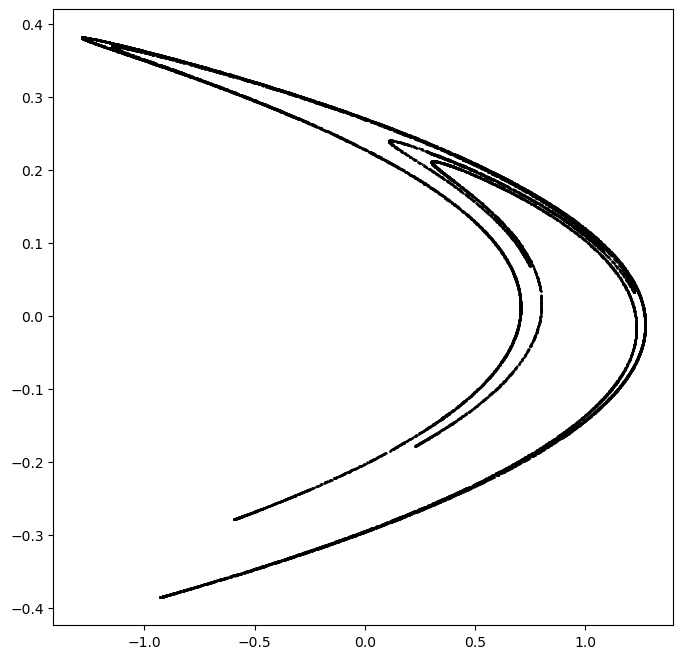

In [78]:
def calc_lyap_w_print(a,b,x, tolerance=1e-7, max_iterations=31*10**4, print_freq=10000):
    """Implementation of the function with a stop condition and N_c=2*10^5. Here we assume that input x is on an attractor,
    and the exceptions of Nans and large numbers were handled earlier"""
    dim=2
    S=np.zeros(dim)
    dxs_=np.eye(dim)
    x_=x
    tolerance_reached=False
    #check_frequency=1000
    L1=np.zeros(dim) 
    L2=np.zeros(dim) #L1 and L2 will be used for the comparisons in the tolerance check
    M=1 #just in case so it's not zero

    print_freq_2=print_freq*5
    print_freq_3=print_freq*10
    
    for i in range(max_iterations):
        #It is sensible to use this form of cycle, if we want to have a maximum acceptable number of iterations anyway
        x, dxs = henon_pert(a,b,x_, dxs_)
        Q, R=LA.qr(dxs)
        d_exp=np.absolute(np.diag(R))
        dS=np.log(d_exp)
        
        x_=x
        dxs_=Q
        S = S + dS
        
        if i!=0 and i%print_freq==0:
            M=i+1
            L2=np.divide(S, M)
            out_str='N: ' + str(M-1)  + ', \t Exps: ' + str(L2[0]) + ',  ' + str(L2[1]) + '. \n'
            if i%print_freq_3==0:
                #out_str='N: ' + str(M-1)  + ', Lyap exps: ' + str(L2[0]) + ',  ' str(L2[1]) + '. \n'
                print(colored(out_str, 'green'))
            elif i%print_freq_2==0:
               print(colored(out_str, 'red'))
            else:
                print(out_str)
            #Gives weird results with  tolerance_reached2=np.allclose(L1,L2,atol=tolerance)
            #tolerance_reached=np.all(LA.norm(L2-L1, np.inf) < tolerance)
            #if tolerance_reached:
                #print("tolerance reached after", M, "iterations \n") #debug print
                #return L2
            #else:
            L1=L2
    #if not tolerance_reached:
    M=max_iterations
    L=np.divide(S,M)
    #ic(M)
    #L=np.divide(S,M)
    return L

def draw_map(a,b,x, n=2*10**4):
    dim=x.shape[0]
    xs=np.zeros((dim,n))
    for i in range(n):
        x_new=henon_map(a,b,x)    #one step of the map
        x=x_new
        xs[:,i]=x
    plt.figure(figsize=(8, 8))
    plt.scatter(xs[0,50:], xs[1,50:],marker='.', s=2, color='k')
    plt.show()

#computing the largest exponent + graph of the sum
a=1.4
b=0.3
dim=2
#rng = np.random.default_rng()
x_0=np.array([0.5, 0.5])#rng.random((self.dim,))
x_attr, ics_converged=skip_ics(a,b,x_0)
print(x_attr, ics_converged)
Ls_true=np.array([0.41904425, -1.62301705])
if ics_converged:
    Ls1=calc_lyap_w_print(a,b,x_attr)
    draw_map(a,b,x_attr)
else:
    print('Did not converge to attractor')



In the cell above, you can notice, how even after more than 100k iterations of the map, quite noticable oscillations of the LEs are oberved. See that the diffrence in values after first 50k iterations and the first 100k is less than $1e-4$, but between 100k and 150k it is larger again. Moreover, the difference between values at 100k iterations and 200k iterations is around $\sim 6 \cdot 10^{-3}$.